# NMF topic analysis of the QAnon conspiracy theory
Eiður Kristinsson EIK20@hi.is

Gísli Már Guðmundsson GMG23@hi.is

# Dataset preprocessing
## Original Datasets
We used two datasets
`Hashed_Q_Submissions_Raw_Combined.csv` of **2.099.875** reddit posts of users. The dataset had 13 different columns of various metadata such as `subreddit`,`numReplies` but we only need three of those columns.

|Column              | Data Type       | Definition       |
|:-------------|:---------------|:---------------|
| **author**   | object         | submission author's Reddit username|
| **text**     | object         | submission selftext, if no text then link post|
| **is_self**  | bool           | indication of text-only submission|


We then used `Hashed_allAuthorStatus.csv`. This dataset held information about each user. Each user had been categorized into two categories, a *QAnon-interesed* and *QAnon-enthusiastic*. While both types follow the QAnon conspiracy in some way, the QAnon-enthusiastic are obsessed with it. In our report we only wanted to analyze the topics of the QAnon-enthusiastic.

|Column              | Data Type       | Definition       |
|:--------|:-------|:-------|
| **QAuthor** | object | The hashed author's Reddit username|
| **isUQ**    | int64  | 0 = QAnon-interested, 1 = QAnon-enthusiastic |
| status  | object | Active, DNE, Is_suspended, (we don't use this) |

## Creating our dataset
We read in both datasets `df_submission` and `df_users`. Then we follow the process defined bellow
1. Filter out all non text submissions (remove `df_submission['is_self'] == False`)
2. Filter out all redundant columns we only keep `text` and `author` for the submissions. Similarly we only keep `isUQ` and `QAuthor` for the user dataframe.
3. Merge the dataframes left on `author` and `QAuthor`. Now our datafram should look like this

|Column              | Data Type       | Definition       |
|:-------------|:---------------|:---------------|
| author   | object         | submission author's Reddit username|
| text     | object         | submission selftext, if no text then link post|
| is_self  | bool           | indication of text-only submission|
| isUQ     | int64  | 0 = QAnon-interested, 1 = QAnon-enthusiastic |

4. remove all rows where `isUQ == 0`
5. Write the `author` and `text` column into a .csv file

# Data preprocessing
Each row of the dataframe is passed through these three functions
1. `stopwords_lemmatizer(string, stopwords)` removes all stopwords from the sentence using a given list of stopwords. then returnes the sentence lemmatized.

2. `remove_links(string)`, removes each part of the string where the word starts with http and to the next empty space.
3. `remove symbols(string)`, removes all non character symbols like "@,(:!)"

After processing each file in the dataframe, we write it down into the file `FullyCleanedDataframe.csv`.

Importing needed libraries for the project

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF


### NMF function

This function takes in $n \times m$ matrix $X$ and $p$ where $p$ is less than both $n$ and $m$.
Here we use the `NMF` from `sklearn` to find $n \times p$ matrix $W$ and $p\times m$ matrix $H$ so
$$
X \approx W H
$$

> Note, we only created the `nmf` for a more readable code.

In [4]:
def nmf(X, p):
    model = NMF(n_components=p, init='random', random_state=0, max_iter=1000)
    W = model.fit_transform(X)
    H = model.components_
    return W,H


Similarly to the `nmf` function this function was only created for more readable code.
the `tfidf_matrix` function takes in a numpy array of documents `D` and some hyperparameters.
We then uses `TfidfVectorizer` to find a Tf-Idf matrix `X` and the vocabulary `vocab`.


In [5]:

def tfidf_matrix(D, min_df = 0.01, max_df=0.1, max_features=1000):
    vectorizer = TfidfVectorizer(
            min_df=min_df,
            max_df=max_df,
            max_features=max_features,
            lowercase=False)
    X = vectorizer.fit_transform(D)
    vocab = vectorizer.get_feature_names_out()
    return X, vocab

In this report the `top_n_words` and `top_n_index` functions are only used for finding the top words of each topic using the `H` matrix from the `nmf` function. However it would also be possible to find the top documents for each topic but since we are working with preprocessed data where stopwords have been removed, the output would not be very readable.

In [6]:

def top_n_index(H, n):
    return [np.argsort(h[:])[-n:] for h in H]

def top_n_words(H,n,vocab):
    indx = top_n_index(H,n)
    return [vocab[i] for i in indx]

Here we import the cleaned Dataframe.

Set the min_df, max_df. the values are so low hence we have a really big dataframe to work with.
max_features is here as an extra safety massure that we cant go over.

Topic count is how many groups we will get

Word_count_per_group is how many words we will display

In [7]:
# ------------------------------

input_file = Path("./data/FullyCleanedDataframe.csv")

min_df = 0.01
max_df = 0.1
max_features = 1000

topic_count = 12
word_count_per_group = 6

# ------------------------------

Here we are reading in the dataframe and cleaning out if there are any empty values

In [8]:
df = pd.read_csv(input_file, encoding='utf-8')
df = df.dropna()

get all documents for tf-idf matrix

In [9]:
D = df['text'].to_numpy()

we are using the function we explained above

In [10]:
X, vocab = tfidf_matrix(
    D,
    min_df,
    max_df,
    max_features
)

Here we are printing out and making sure we have the right shape

In [11]:
print(X.shape, vocab.shape)

(103811, 773) (773,)


we are using the function we explained above

In [12]:
W, H = nmf(X,topic_count)

Here we are printing out and making sure we have the right shape

In [13]:
print(X.shape, " = ", W.shape, H.shape)

(103811, 773)  =  (103811, 12) (12, 773)


we are using the function we explained above

In [14]:
top_words = top_n_words(H,word_count_per_group, vocab)

Here we are printing out the reslults

Each line containing each topic

In [15]:
label_count = 3 # for graph visualization
labels = []
for group in top_words:
    g = np.flip(group)
    print(g)
    labels.append(g[-label_count:])

['clinton' 'fbi' 'investig' 'report' 'hillari' 'email']
['god' 'love' 'bless' 'jesus' 'life' 'lord']
['guy' 'fuck' 'shit' 'bad' 'hey' 'woman']
['game' 'play' 'player' 'team' 'fun' 'win']
['news' 'fake' 'medium' 'report' 'stori' 'msm']
['tweet' 'check' 'twitter' 'potus' 'account' 'messag']
['ampxb' 'process' 'donald' 'player' 'sign' 'price']
['video' 'watch' 'youtub' 'channel' 'minut' 'interview']
['amp' 'red' 'stay' 'patriot' 'pill' 'board']
['start' 'feel' 'happen' 'read' 'lot' 'talk']
['link' 'articl' 'comment' 'reddit' 'info' 'search']
['presid' 'govern' 'control' 'countri' 'war' 'power']


## Graph visualisation

Now we know what topics the QAnon conspiracy is about but how do they connect? 
The `W` matrix declared above shows the connection between sentences and what topics they fall into, e.g. if `W[i,j] == 0` then sentence `i` is not about topic `j`.
If we calculate the cosine similarity between the columns of `W` we can get a matrix that shows how much topics are correlated.

In [16]:
import networkx as nx 

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

weight_matrix = cosine_similarity(W.T)

If we then create a weighted undirected graph from the `weight_matrix` we can see how the topics are correlated.
Here we create a method that takes in the `weight_matrix`, `labels` for the nodes (topics) and `lam` a hyperparameter specifying a minimum weight threshold.

In [17]:
def visualize_graph(weights, labels, lam):
    G = nx.Graph()
    n = len(weights)

    for i in range(n):
        for j in range(i+1, n):
            w = weights[i][j]
            if w > lam or lam == -1:
                G.add_edge(i, j, weight=w)
    pos = nx.spring_layout(G)

    edges = G.edges(data=True)
    wts = [d['weight'] for (_,_,d) in edges]
    nx.draw(G, pos, with_labels=False, edge_color=wts, edge_cmap=plt.cm.Blues, node_size=1600)
    node_labels = {i: "\n".join(labels[i]) for i in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10)
    plt.show()

We recommend setting `topic_count = 60` and `lam = 0.125`

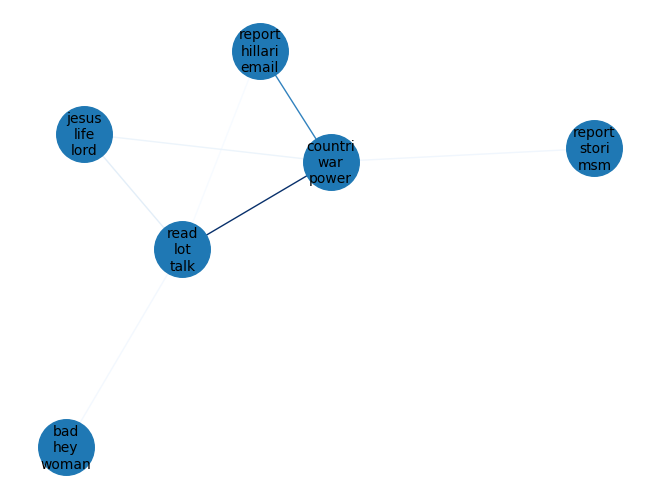

In [19]:
visualize_graph(weight_matrix, labels, 0.2)


# Results
  interpration of a few topics from the analysis

  1.topic of FBI investigating Hillary Clinton and Obama, and the connection between the Hillary  email  and Russia.

  2.Cristianity and evil lords, other religious topics.

  5.Fake news, cnn but we can also see a clear connection between the QAnon conspiracy and Trump's truth social  platform.
  
  12.Nationalistic  topics about war, power and the government.
  
